In [124]:
from rdkit.Chem import MACCSkeys                       #MACCS Keys
from rdkit import Chem, DataStructs
from rdkit.ML.Cluster import Butina

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

def fingerprint_bitgenerator(fps):
    np_fps = []
    
    for fp in fps:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp,arr)
        np_fps.append(arr)
        
    return np_fps


def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

wdir = '/Users/beomjin_seo/Documents/work_space/kist-europe/QSAR/AOP_data/'
csv = 'final_ic50.csv'

df = pd.read_csv(wdir+csv)
df['Standard Value'].dropna(axis=0)
smi = df['Canonical Smiles']
sd = [Chem.MolFromSmiles(m) for m in smi]

maccfps = [MACCSkeys.GenMACCSKeys(m) for m in sd]

clusters=ClusterFps(maccfps,cutoff=0.5)
cluster_list = list(clusters)


t1 = DataStructs.TanimotoSimilarity(maccfps[0],maccfps[1])
t2 = DataStructs.BulkAllBitSimilarity(maccfps[0],(maccfps[:6]))
t3 = DataStructs.BulkTanimotoSimilarity(maccfps[0],maccfps[:])


BulkTanimotoSimilarity use > get dists <br> 
get cluster myself <br> 
ClusterFps has many limitations. 

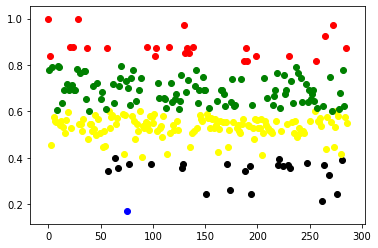

In [148]:
# using t3 data ,, 
# if the value is  
# 0-0.2  >>> class0
# 0.2 - 0.4 >>> class1 
# 0.4 - 0.6 >>> class2 
# 0.6 - 0.8 >>> class3 
# 0.8 - 1.0 >>> class4 

class0, class1, class2, class3, class4 = [], [], [], [], []
class0_x, class1_x, class2_x, class3_x, class4_x = [], [], [], [], []


for i in range(len(t3)):
    if 0.0 <= t3[i] <= 0.2: 
        class0.append(t3[i])
        class0_x.append(i)
    elif 0.2 < t3[i] <= 0.4 :
        class1.append(t3[i])
        class1_x.append(i)
    elif 0.4 < t3[i] <= 0.6 :
        class2.append(t3[i])
        class2_x.append(i)
    elif 0.6 < t3[i] <= 0.8 :
        class3.append(t3[i])
        class3_x.append(i)
    elif 0.8 < t3[i] <= 1.0 : 
        class4.append(t3[i])
        class4_x.append(i)
    
    
df0 = pd.DataFrame(class0)
plt.scatter(class0_x,class0,c='blue',label='class0')
plt.scatter(class1_x,class1,c='black',label='class1')
plt.scatter(class2_x,class2,c='yellow',label='class2')
plt.scatter(class3_x,class3,c='green',label='class3')
plt.scatter(class4_x,class4,c='red',label='class4')
plt.show()


# 이제 이 값들을 sim 값에 따라 class 를 분류했으니, 이들의 스탠다드 밸류의 유사성과 연관지어봐
# Standard value와 SMILES 옆에 sim column 을 만들고 sim column에 대해 
# class를 0-4까지 나눈 하나의 칼럼을 또 만들어 
# 그리고 각 레이블 내에서 standard value를 비교해보도록.

(0, 1500)

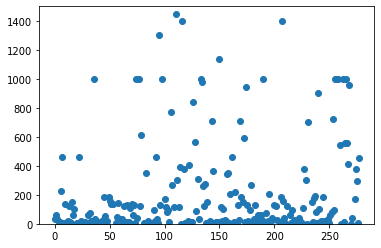

In [163]:
std_val = df['Standard Value'].dropna(axis=0)
std_val_list = std_val.values.tolist()
std_val_x = []
for i in range(278):
    std_val_x.append(i)
    

plt.scatter(std_val_x,std_val_list)
plt.ylim(0,1500)

# 명확하지 못한 것 같다. 분류한 class 별로 따로 std_val 비교해야 할듯

In [181]:
df_sim = pd.DataFrame(t3)
df_result = pd.concat([std_val, df_sim], axis=1, ignore_index=True)
df_result.columns = ['Standard_Value', 'Similarity']
df_result

,Standard_Value,Similarity
0,32.36,1.000000
1,60.26,0.777778
2,32.36,0.837209
3,1600.00,0.454545
4,1.70,0.790698
...,...,...
282,173.78,0.777778
283,376.00,0.622222
284,298.00,0.577778
285,8.60,0.875000


In [193]:
cluster_label = []

for row in df_result['Similarity']:
    if row >= 0.8 : 
        cluster_label.append('c4')
    elif row >= 0.6 : 
        cluster_label.append('c3')
    elif row >= 0.4 : 
        cluster_label.append('c2')
    elif row >= 0.2 : 
        cluster_label.append('c1')
    else : 
        cluster_label.append('c0')
        
df_result['cluster_label'] = cluster_label 

# 특정 레이블을 선택, std_val을 list 로 뽑아서 만들기 
df_result
    

,Standard_Value,Similarity,cluster_label
0,32.36,1.000000,c4
1,60.26,0.777778,c3
2,32.36,0.837209,c4
3,1600.00,0.454545,c2
4,1.70,0.790698,c3
...,...,...,...
282,173.78,0.777778,c3
283,376.00,0.622222,c3
284,298.00,0.577778,c2
285,8.60,0.875000,c4


In [232]:
c0_stdval,c1_stdval,c2_stdval,c3_stdval,c4_stdval = [],[],[],[],[]
c0_stdval_x,c1_stdval_x,c2_stdval_x,c3_stdval_x,c4_stdval_x = [],[],[],[],[]

for i in range(len(df_result)):
    if df_result.loc[i]['cluster_label'] == 'c4' :
        c4_stdval.append(df_result.loc[i]['Standard_Value'])
        c4_stdval_x.append(i)
    elif df_result.loc[i]['cluster_label'] == 'c3':
        c3_stdval.append(df_result.loc[i]['Standard_Value'])
        c3_stdval_x.append(i)
    elif df_result.loc[i]['cluster_label'] == 'c2':
        c2_stdval.append(df_result.loc[i]['Standard_Value'])
        c2_stdval_x.append(i)
    elif df_result.loc[i]['cluster_label'] == 'c1':
        c1_stdval.append(df_result.loc[i]['Standard_Value'])
        c1_stdval_x.append(i)
    else :
        c0_stdval.append(df_result.loc[i]['Standard_Value'])
        c0_stdval_x.append(i)
        


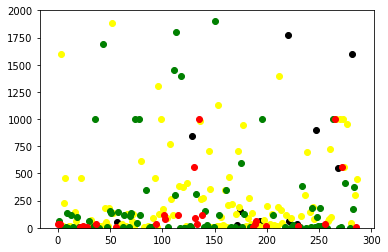

In [233]:
plt.scatter(c0_stdval_x,c0_stdval,c='blue',label='class0')
plt.scatter(c1_stdval_x,c1_stdval,c='black',label='class1')
plt.scatter(c2_stdval_x,c2_stdval,c='yellow',label='class2')
plt.scatter(c3_stdval_x,c3_stdval,c='green',label='class3')
plt.scatter(c4_stdval_x,c4_stdval,c='red',label='class4')
plt.ylim(0,2000)
plt.show()

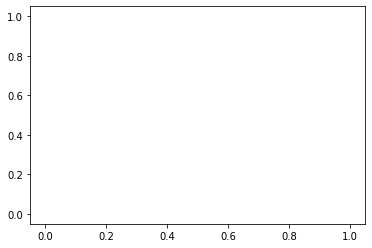

In [234]:
plt.scatter(c0_stdval_x,c0_stdval,c='blue',label='class0')

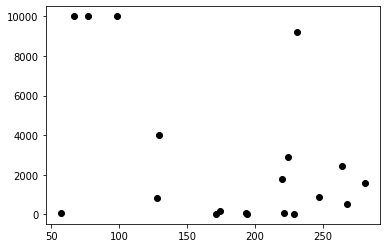

In [235]:
plt.scatter(c1_stdval_x,c1_stdval,c='black',label='class1')

(0, 12000)

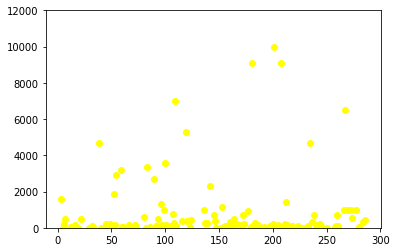

In [236]:
plt.scatter(c2_stdval_x,c2_stdval,c='yellow',label='class2')
plt.ylim(0,12000)

(0, 12000)

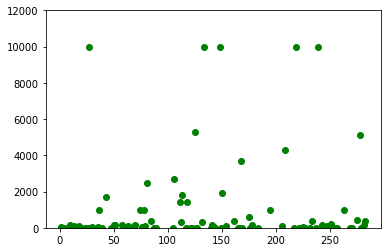

In [229]:
plt.scatter(c3_stdval_x,c3_stdval,c='green',label='class3')
plt.ylim(0,12000)

(0, 200)

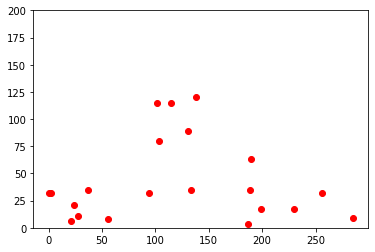

In [237]:
plt.scatter(c4_stdval_x,c4_stdval,c='red',label='class4')
plt.ylim(0,200)

-------

In [1]:
from rdkit.Chem import MACCSkeys                       #MACCS Keys
from rdkit import Chem, DataStructs
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

def fingerprint_bitgenerator(fps):
    np_fps = []
    
    for fp in fps:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp,arr)
        np_fps.append(arr)
        
    return np_fps

wdir = '/Users/beomjin_seo/Documents/work_space/kist-europe/QSAR/AOP_data/'
csv = 'final_ic50.csv'

df = pd.read_csv(wdir+csv)
df['Standard Value'].dropna(axis=0)
smi = df['Canonical Smiles']
sd = [Chem.MolFromSmiles(m) for m in smi]

maccfps = [MACCSkeys.GenMACCSKeys(m) for m in sd]

print('Num of available data : ', len(maccfps))

sim = [[ 0 for j in range(len(maccfps))] for i in range(len(maccfps))]
non_duplicated_sim_val = set()
for i in range(len(maccfps)):
    j = i
    for j in range(len(maccfps)):
        sim[i][j] = DataStructs.FingerprintSimilarity(maccfps[i],maccfps[j])
        non_duplicated_sim_val.add(sim[i][j])
    
df_sim = pd.DataFrame(sim)
sim_list = df_sim.values.tolist()


   

RDKit WARNING: [15:04:13] Enabling RDKit 2019.09.3 jupyter extensions


[<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee45d0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee4620>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee4670>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee46c0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee4710>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee4760>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee47b0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee4800>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee4850>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee48a0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee48f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee4940>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124ee4990>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x124

In [ ]:
'''

std_val = df['Standard Value']
std_val = df.dropna(axis=0)
std_val = std_val.values.tolist()
std_val_list = [[ 0 for j in range(len(maccfps))] for i in range(len(maccfps))]
for i in range(len(maccfps)):
    #j = i 
    for j in range(len(maccfps)):
        std_val_list[i][j] = abs(std_val[i]-std_val[j])
        
        
#print(type(sim_val),len(sim_val))
#print(type(std_val_list),len(std_val_list))


        
plt.hist2d(sim_list,std_val_list,bins=30)
plt.show()
'''

(array([ 8.,  8., 31., 45., 61., 54., 58., 47., 57., 54., 57., 50., 55.,
        48., 51., 50., 45., 43., 38., 43., 40., 33., 36., 32., 32., 30.,
        30., 23., 23., 13.]),
 array([0.0952381 , 0.12539683, 0.15555556, 0.18571429, 0.21587302,
        0.24603175, 0.27619048, 0.30634921, 0.33650794, 0.36666667,
        0.3968254 , 0.42698413, 0.45714286, 0.48730159, 0.51746032,
        0.54761905, 0.57777778, 0.60793651, 0.63809524, 0.66825397,
        0.6984127 , 0.72857143, 0.75873016, 0.78888889, 0.81904762,
        0.84920635, 0.87936508, 0.90952381, 0.93968254, 0.96984127,
        1.        ]),
 <a list of 30 Patch objects>)

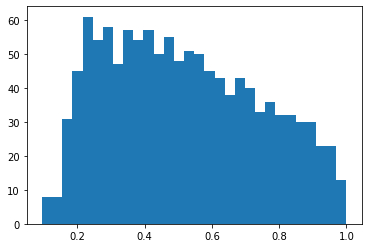

In [181]:
non_duplicated_sim_val = list(non_duplicated_sim_val)
non_duplicated_sim_val.sort()
plt.hist(sim_val,bins=30)

In [182]:
for i in range(len(df_sim)):
    for j in range(len(df_sim)):
        df_sim[i][j] = round(df_sim[i][j],1)

In [185]:
molcule_num = 0
df_sim = df_sim[0:1]
df_sim

,0,1,2,3,4,5,6,7,8,9,...,277,278,279,280,281,282,283,284,285,286
0,1.0,0.8,0.8,0.5,0.8,0.6,0.6,0.6,0.6,0.8,...,0.6,0.6,0.7,0.4,0.4,0.8,0.6,0.6,0.9,0.5


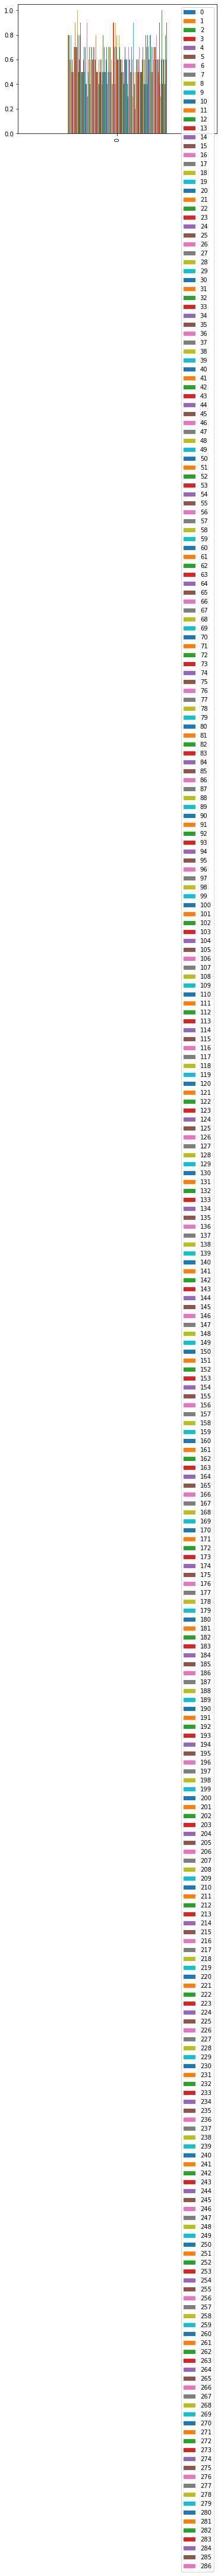

In [189]:
df_sim.plot(kind='bar')

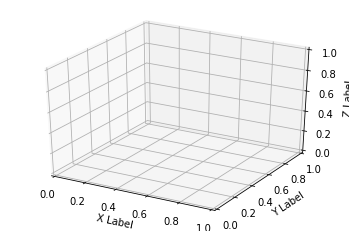

In [96]:
#Axes3D.scatter(xs, ys, zs=0, zdir='z', s=20, c=None, depthshade=True, *args, **kwargs)
from mpl_toolkits.mplot3d import Axes3D

std_val = df['Standard Value']
std_val = df.dropna(axis=0)
std_val = std_val.values.tolist()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(std_val)):
    for c, m, zlow, zhigh in [('r', 'o', 0.0, 0.2), ('b', 'o', 0.2, 0.4),('k', 'o', 0.4, 0.6),('y', 'o', 0.6, 0.8),('b', 'o', 0.8, 1.0)]:
        xs = range(278)
        ys = std_val[i]
        zs = range(278)
        ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()